# Introduction

This data analysis work deals with an IMDb Movie Ranking database. The research goal is to answer the following questions:

1. Which genres are the most popular from year to year?
2. What are the three most relevant properties associated with movies that have high revenues?
3. What are the three most relevant properties associated with movies that have high profits?

It should be noted that this analysis is tentative and subject to further scrutiny - especially with regards to more sophisticated statistical analysis. 

This is my methodology:
1. Loading the database
2. Investigate the database
3. Wrangle the data
4. Analyse the data as to:
4a. Answer Q1
4b. Answer Q2
4c. Answer Q3

# Data investigation

In [1131]:
# Step 1: Loading the database
import pandas as pd
import numpy as np

df = pd.read_csv('tmdb-movies.csv')

In [1132]:
# Step 2: Investigate the database
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [1133]:
df.duplicated().sum()

1

In [1134]:
df.isna().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [1135]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


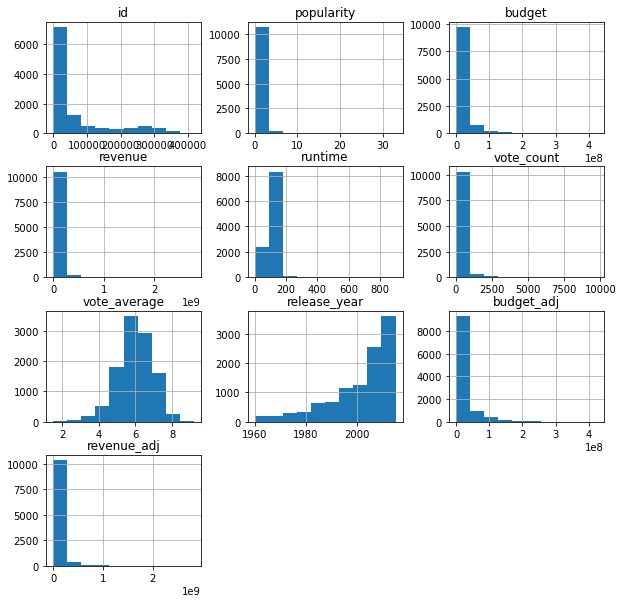

In [1136]:
%matplotlib inline

df.hist(figsize= (10,10));

# Data Wrangling

Data investigation findings:

Data types:
- Column release day has a dtype of int. This should be converted into datetime format

Format:
- Columns "cast" / "genres" / "production company" record numerous entries in one cell. To analyse individual factors, these entries will be spread across multiple rows

Data integrity:
- The database features one duplicated row. This row will be dropped.
- All rows with empty values will be dropped (cast, director, keywords, production companies)
- Every movie with a adj revenue or budget of 0 will be dropped

Data meaningfulness:
- I assume that movie overview, keywords, homepage, tagline, id, vote_count and imdb_id do not have an impact on our dependent variables. These columns will be droped.
- Individual dates are presumably less predictive of our dependent variables. Instead, dates will be broked down into release year and release month, which will be used to calculate seasonality
- The revenue and budget columne will be dropped. I will focuse on the adjusted data
- Runtime, vote average and budget are too heterogenous to analyse. As a result, these properties will be clustered into groups

Additional columns for analysis:
- The database does not have a record of seasonality with regards to its release date. This will be calculated
- The data misses a movie profit column. This will be calculated based on the budget and revenues

In [1137]:
# Data wrangling - converting release_date to datetime

df['release_date'] = pd.to_datetime(df['release_date'])

df['release_date'].sort_values()


9952    1971-01-15
9961    1971-01-31
9972    1971-02-10
9940    1971-03-03
9932    1971-03-11
           ...    
10663   2070-12-14
10665   2070-12-14
10654   2070-12-16
10681   2070-12-18
10648   2070-12-24
Name: release_date, Length: 10866, dtype: datetime64[ns]

In [1138]:
# Data wrangling - drop movies with a release year greater than 2015

df['release_year'] = df['release_date'].dt.year

df = df.drop(df[df.release_year > 2016].index)


In [1139]:
# Data wrangling - split cast, genres, production companies, key words

df = df.assign(cast=df['cast'].str.split('|')).explode('cast')

df = df.assign(genres=df['genres'].str.split('|')).explode('genres')

df = df.assign(director=df['director'].str.split('|')).explode('director')

df = df.assign(production_companies=df['production_companies'].str.split('|')).explode('production_companies')


In [1140]:
# Dropping overview, homepage, tagline, revenue, budget, imdb_id columns

df = df.drop(columns = ['revenue', 'budget', 'overview', 'homepage', 'tagline', 'keywords','imdb_id', 'id','vote_count'])

In [1141]:
# Dropping empty and duplicated rows

df = df.dropna()

df = df.drop_duplicates()

In [1142]:
# Dropping movies with no revenues or budget

df = df.drop(df[df.budget_adj == 0].index)

df = df.drop(df[df.budget_adj < 0].index)

df = df.drop(df[df.revenue_adj == 0].index)

df = df.drop(df[df.revenue_adj < 0].index)

df.sort_values('revenue_adj')

,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget_adj,revenue_adj
5067,0.462609,Shattered Glass,Peter Sarsgaard,Billy Ray,94,Drama,Cruise/Wagner Productions,2003-11-14,6.4,2003,7.112116e+06,2.370705e+00
5067,0.462609,Shattered Glass,Rosario Dawson,Billy Ray,94,History,Baumgarten Merims Productions,2003-11-14,6.4,2003,7.112116e+06,2.370705e+00
5067,0.462609,Shattered Glass,Peter Sarsgaard,Billy Ray,94,Drama,Lions Gate Films,2003-11-14,6.4,2003,7.112116e+06,2.370705e+00
5067,0.462609,Shattered Glass,Rosario Dawson,Billy Ray,94,History,Cruise/Wagner Productions,2003-11-14,6.4,2003,7.112116e+06,2.370705e+00
5067,0.462609,Shattered Glass,Rosario Dawson,Billy Ray,94,History,Lions Gate Films,2003-11-14,6.4,2003,7.112116e+06,2.370705e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
1386,9.432768,Avatar,Zoe Saldana,James Cameron,162,Science Fiction,Dune Entertainment,2009-12-10,7.1,2009,2.408869e+08,2.827124e+09
1386,9.432768,Avatar,Zoe Saldana,James Cameron,162,Science Fiction,Twentieth Century Fox Film Corporation,2009-12-10,7.1,2009,2.408869e+08,2.827124e+09
1386,9.432768,Avatar,Zoe Saldana,James Cameron,162,Science Fiction,Ingenious Film Partners,2009-12-10,7.1,2009,2.408869e+08,2.827124e+09
1386,9.432768,Avatar,Sigourney Weaver,James Cameron,162,Adventure,Lightstorm Entertainment,2009-12-10,7.1,2009,2.408869e+08,2.827124e+09


In [1143]:
# determining movie profits

df['proft_adj'] = df['revenue_adj'] - df['budget_adj']

In [1144]:
# determining seasonality of release

seasons = {12 : "Winter",
           1 : "Winter",
           2 : "Winter",
           3 : "Spring",
           4 : "Spring",
           5 : "Spring",
           6 : "Summer", 
          7 : "Summer",
           8: "Summer",
           9 : "Autumn",
           10 : "Autumn",
           11 : "Autumn"}

df['release_month'] = df['release_date'].dt.month

df['seasonality'] = df['release_month'].map(seasons)

df = df.drop(columns = ['release_month', 'release_date'])

In [1145]:
# spliting runtime into categories

cat_run_1 = 90
cat_run_2 = 150
cat_run_3 = 180

# create runtime conditions
conditions = [
    (df['runtime'] <= cat_run_1),
    (df['runtime'] <= cat_run_2) & (df['runtime'] >= cat_run_1),
    (df['runtime'] <= cat_run_3) & (df['runtime'] >= cat_run_2),
    (df['runtime'] >= cat_run_3)
    ]

# create a list of the values I want to assign for each condition
runtime_categories = ['Runtime_lower_90',
                      'Runtime_90_150',
                      'Runtime_150_180',
                      'Runtime_higher_180'
                     ]

df['runtime_categories'] = np.select(conditions, runtime_categories)


In [1146]:
# spliting popularity into categories

cat_pop_1 = 1
cat_pop_2 = 10
cat_pop_3 = 20
cat_pop_4 = 30

# create runtime conditions
conditions = [
    (df['popularity'] <= cat_pop_1),
    (df['popularity'] <= cat_pop_2) & (df['popularity'] >= cat_pop_1),
    (df['popularity'] <= cat_pop_3) & (df['popularity'] >= cat_pop_2),
    (df['popularity'] <= cat_pop_4) & (df['popularity'] >= cat_pop_3),
    (df['popularity'] >= cat_pop_4)
    ]

# create a list of the values I want to assign for each condition
popularity_categories = ['popularity_lower_1',
                         'popularity_1_10',
                         'popularity_10_20',
                         'popularity_20_30',
                         'popularity_higher_30'
                        ]

df['popularity_categories'] = np.select(conditions, popularity_categories)

In [1147]:
# spliting vote_averages into categories

cat_vote_1 = 1
cat_vote_2 = 4
cat_vote_3 = 6
cat_vote_4 = 8
cat_vote_5 = 10

# create vote conditions
conditions = [
    (df['vote_average'] <= cat_vote_1),
    (df['vote_average'] <= cat_vote_2) & (df['vote_average'] >= cat_vote_1),
    (df['vote_average'] <= cat_vote_3) & (df['vote_average'] >= cat_vote_2),
    (df['vote_average'] <= cat_vote_4) & (df['vote_average'] >= cat_vote_3),
    (df['vote_average'] <= cat_vote_5) & (df['vote_average'] >= cat_vote_4),
    (df['vote_average'] >= cat_vote_5)
    ]

# create a list of the values I want to assign for each condition
vote_categories = ['vote_lower_1',
                   'vote_1_4',
                   'vote_4_6',
                   'vote_6_8',
                   'vote_8_10',
                   'vote_higher_10'
                  ]

df['vote_categories'] = np.select(conditions, vote_categories)

In [1148]:
# spliting budget_adj into categories

cat_budget_1 = 1000000
cat_budget_2 = 10000000
cat_budget_3 = 50000000
cat_budget_4 = 100000000
cat_budget_5 = 200000000
cat_budget_6 = 300000000
cat_budget_7 = 400000000

# create vote conditions
conditions = [
    (df['budget_adj'] <= cat_budget_1),
    (df['budget_adj'] <= cat_budget_2) & (df['budget_adj'] >= cat_budget_1),
    (df['budget_adj'] <= cat_budget_3) & (df['budget_adj'] >= cat_budget_2),
    (df['budget_adj'] <= cat_budget_4) & (df['budget_adj'] >= cat_budget_3),
    (df['budget_adj'] <= cat_budget_5) & (df['budget_adj'] >= cat_budget_4),
    (df['budget_adj'] <= cat_budget_6) & (df['budget_adj'] >= cat_budget_5),
    (df['budget_adj'] <= cat_budget_7) & (df['budget_adj'] >= cat_budget_6),
    (df['budget_adj'] >= cat_budget_7)
    ]

# create a list of the values I want to assign for each condition
budget_categories = ['budget_lower_1M',
                     'budget_1M_10M',
                     'budget_10M_50M',
                     'budget_50M_100M',
                     'budget_100M_200M',
                     'budget_200M_300M',
                     'budget_300M_400M',
                     'budget_higher_400M'
                  ]

df['budget_categories'] = np.select(conditions, budget_categories)


# Data evaluation

In [1149]:
# 1. Which genres are the most popular from year to year?
# 2. What are the three most relevant properties associated with movies that have high revenues?


## QUESTION 1

In [1150]:
# 1: Which genres are the most popular from year to year?
# I will define popular according to the popularity score, vote_average and revenues

df_2 = df.drop_duplicates('original_title')

df_2_popularity = df_2.groupby(['release_year','genres']).mean().sort_values(['release_year', 'popularity'], ascending = False)

df_2_popularity.head(100)

popularity     runtime  vote_average  \
release_year genres                                                  
2015         Western            9.110700  156.000000      7.200000   
             Action             6.269757  116.500000      6.312500   
             War                5.476958  136.000000      6.500000   
             Science Fiction    4.871351  117.200000      6.100000   
             Family             3.583583   97.000000      5.833333   
             Adventure          3.207031  105.909091      6.427273   
             Crime              2.752810  120.000000      6.472727   
             Romance            2.561794  111.000000      6.966667   
             Fantasy            2.413384  101.750000      6.375000   
             Comedy             2.029507  106.307692      6.219231   
             History            1.992779  121.000000      6.350000   
             Mystery            1.842068  109.750000      5.825000   
             Thriller           1.721857  103.666667      5.588889   
             Drama              1.670796  114.534884      6.327907   
             Animation          1.592701   89.500000      6.750000   
             Horror             1.463954   91.750000      5.375000   
2014         Adventure          8.643406  123.857143      6.742857   
             History            4.932709  120.000000      7.750000   
             Science Fiction    4.334091  122.428571      6.200000   
             Action             4.225755  111.840000      6.312000   
             Mystery            3.677581  122.000000      7.250000   
             Fantasy            3.355820  108.000000      6.766667   
             War                3.237968  124.750000      6.850000   
             Crime              2.928647  108.666667      6.500000   
             Comedy             1.734131  103.384615      6.192308   
             Thriller           1.574654  106.250000      5.750000   
             Romance            1.472919  105.800000      6.520000   
             Drama              1.447326  113.414634      6.560976   
             Animation          1.422567   90.600000      6.560000   
             Horror             1.245107   93.538462      5.530769   
             Family             1.216261   92.250000      6.300000   
             Music              1.192867  126.500000      6.400000   
             Western            0.870104  122.000000      6.200000   
2013         Science Fiction    2.975345  107.750000      6.375000   
             Crime              2.223927  123.750000      6.400000   
             Adventure          1.963309  121.285714      6.657143   
             Action             1.868510  116.228571      6.191429   
             Romance            1.853013  116.333333      7.233333   
             Animation          1.799865   94.000000      6.216667   
             Thriller           1.193143  110.076923      5.938462   
             Fantasy            1.170054  107.000000      5.466667   
             Horror             1.167345   96.363636      5.727273   
             Drama              1.021471  113.302326      6.474419   
             Comedy             1.020187  102.233333      6.093333   
             Mystery            0.412492   99.000000      5.400000   
             Music              0.387599  104.333333      6.133333   
             Western            0.387592   95.000000      5.700000   
             History            0.273681   94.000000      5.800000   
             War                0.010335  131.000000      5.500000   
2012         Fantasy            4.431943   92.500000      6.450000   
             Science Fiction    2.704094  120.500000      6.666667   
             Adventure          2.079435  120.111111      6.066667   
             Action             1.927235  107.964286      5.917857   
             Family             1.752577   99.000000      6.800000   
             Animation          1.667385   89.125000      5.912500   
             Music              1.496861

In [1151]:
df_2_vote = df_2.groupby(['release_year','genres']).mean().sort_values(['release_year', 'vote_average'], ascending = False)

df_2_vote.head(100)

popularity     runtime  vote_average  \
release_year genres                                                  
2015         Western            9.110700  156.000000      7.200000   
             Romance            2.561794  111.000000      6.966667   
             Animation          1.592701   89.500000      6.750000   
             War                5.476958  136.000000      6.500000   
             Crime              2.752810  120.000000      6.472727   
             Adventure          3.207031  105.909091      6.427273   
             Fantasy            2.413384  101.750000      6.375000   
             History            1.992779  121.000000      6.350000   
             Drama              1.670796  114.534884      6.327907   
             Action             6.269757  116.500000      6.312500   
             Comedy             2.029507  106.307692      6.219231   
             Science Fiction    4.871351  117.200000      6.100000   
             Family             3.583583   97.000000      5.833333   
             Mystery            1.842068  109.750000      5.825000   
             Thriller           1.721857  103.666667      5.588889   
             Horror             1.463954   91.750000      5.375000   
2014         History            4.932709  120.000000      7.750000   
             Mystery            3.677581  122.000000      7.250000   
             War                3.237968  124.750000      6.850000   
             Fantasy            3.355820  108.000000      6.766667   
             Adventure          8.643406  123.857143      6.742857   
             Drama              1.447326  113.414634      6.560976   
             Animation          1.422567   90.600000      6.560000   
             Romance            1.472919  105.800000      6.520000   
             Crime              2.928647  108.666667      6.500000   
             Music              1.192867  126.500000      6.400000   
             Action             4.225755  111.840000      6.312000   
             Family             1.216261   92.250000      6.300000   
             Science Fiction    4.334091  122.428571      6.200000   
             Western            0.870104  122.000000      6.200000   
             Comedy             1.734131  103.384615      6.192308   
             Thriller           1.574654  106.250000      5.750000   
             Horror             1.245107   93.538462      5.530769   
2013         Romance            1.853013  116.333333      7.233333   
             Adventure          1.963309  121.285714      6.657143   
             Drama              1.021471  113.302326      6.474419   
             Crime              2.223927  123.750000      6.400000   
             Science Fiction    2.975345  107.750000      6.375000   
             Animation          1.799865   94.000000      6.216667   
             Action             1.868510  116.228571      6.191429   
             Music              0.387599  104.333333      6.133333   
             Comedy             1.020187  102.233333      6.093333   
             Thriller           1.193143  110.076923      5.938462   
             History            0.273681   94.000000      5.800000   
             Horror             1.167345   96.363636      5.727273   
             Western            0.387592   95.000000      5.700000   
             War                0.010335  131.000000      5.500000   
             Fantasy            1.170054  107.000000      5.466667   
             Mystery            0.412492   99.000000      5.400000   
2012         Family             1.752577   99.000000      6.800000   
             Science Fiction    2.704094  120.500000      6.666667   
             Music              1.496861   99.000000      6.600000   
             Documentary        0.050524   93.000000      6.500000   
             Fantasy            4.431943   92.500000      6.450000   
             Drama              1.204391  115.194444      6.291667   
             Crime              1.194670

In [1152]:
df_2_revenue = df_2.groupby(['release_year','genres']).mean().sort_values(['release_year', 'revenue_adj'], ascending = False)

df_2_revenue.head(100)

popularity     runtime  vote_average  \
release_year genres                                                  
2015         War                5.476958  136.000000      6.500000   
             Western            9.110700  156.000000      7.200000   
             Family             3.583583   97.000000      5.833333   
             Action             6.269757  116.500000      6.312500   
             Science Fiction    4.871351  117.200000      6.100000   
             Animation          1.592701   89.500000      6.750000   
             Adventure          3.207031  105.909091      6.427273   
             Romance            2.561794  111.000000      6.966667   
             Fantasy            2.413384  101.750000      6.375000   
             Comedy             2.029507  106.307692      6.219231   
             Crime              2.752810  120.000000      6.472727   
             Horror             1.463954   91.750000      5.375000   
             Drama              1.670796  114.534884      6.327907   
             Thriller           1.721857  103.666667      5.588889   
             Mystery            1.842068  109.750000      5.825000   
             History            1.992779  121.000000      6.350000   
2014         Fantasy            3.355820  108.000000      6.766667   
             Adventure          8.643406  123.857143      6.742857   
             Science Fiction    4.334091  122.428571      6.200000   
             Action             4.225755  111.840000      6.312000   
             War                3.237968  124.750000      6.850000   
             Animation          1.422567   90.600000      6.560000   
             Mystery            3.677581  122.000000      7.250000   
             History            4.932709  120.000000      7.750000   
             Family             1.216261   92.250000      6.300000   
             Music              1.192867  126.500000      6.400000   
             Romance            1.472919  105.800000      6.520000   
             Comedy             1.734131  103.384615      6.192308   
             Horror             1.245107   93.538462      5.530769   
             Thriller           1.574654  106.250000      5.750000   
             Crime              2.928647  108.666667      6.500000   
             Drama              1.447326  113.414634      6.560976   
             Western            0.870104  122.000000      6.200000   
2013         Animation          1.799865   94.000000      6.216667   
             Adventure          1.963309  121.285714      6.657143   
             Science Fiction    2.975345  107.750000      6.375000   
             Action             1.868510  116.228571      6.191429   
             Fantasy            1.170054  107.000000      5.466667   
             Crime              2.223927  123.750000      6.400000   
             Comedy             1.020187  102.233333      6.093333   
             Horror             1.167345   96.363636      5.727273   
             War                0.010335  131.000000      5.500000   
             Romance            1.853013  116.333333      7.233333   
             Drama              1.021471  113.302326      6.474419   
             Thriller           1.193143  110.076923      5.938462   
             Music              0.387599  104.333333      6.133333   
             History            0.273681   94.000000      5.800000   
             Mystery            0.412492   99.000000      5.400000   
             Western            0.387592   95.000000      5.700000   
2012         Science Fiction    2.704094  120.500000      6.666667   
             Adventure          2.079435  120.111111      6.066667   
             Animation          1.667385   89.125000      5.912500   
             Family             1.752577   99.000000      6.800000   
             Action             1.927235  107.964286      5.917857   
             Fantasy            4.431943   92.500000      6.450000   
             Music              1.496861

## QUESTION 2

In [1153]:
# 2: What are the three most relevant properties associated with movies that have high revenues?
# The following properties will be analysed:
    # popularity score, cast, director, runetime category, genres,
    # production_companies, vote_average, budget_adjusted, seasonality

# I define the most relevant properties as those that feature the highest mean revenue per unique property

In [1154]:
# mean revenues per popularity score

df_pop = df.drop_duplicates('original_title')[['popularity_categories', 'original_title', 'revenue_adj']]

df_pop_result = df_pop.groupby('popularity_categories').mean().sort_values('revenue_adj')

df_pop_result

,revenue_adj
popularity_categories,
popularity_lower_1,6.065957e+07
popularity_1_10,2.417979e+08
popularity_20_30,4.604260e+08
popularity_10_20,9.974678e+08
popularity_higher_30,1.392446e+09


In [1155]:
# mean revenues per cast

df_cast = df[['original_title', 'cast', 'revenue_adj']]

df_cast_2 = df_cast.original_title.str.cat(df_cast.cast)

df_cast['help'] = df_cast[['original_title', 'cast']].agg('-'.join, axis=1)

df_cast = df_cast.drop_duplicates('help')

df_cast = df_cast.drop(columns = ['help'])

df_cast_result = df_cast.groupby('cast').mean().sort_values('revenue_adj')

df_cast_result


<ipython-input-1155-be3c39017a73>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cast['help'] = df_cast[['original_title', 'cast']].agg('-'.join, axis=1)


,revenue_adj
cast,
Jeremy London,2.861934e+00
Shannen Doherty,2.861934e+00
Kevin Michael Richardson,5.926763e+00
Clayton Watson,5.926763e+00
John Demita,5.926763e+00
...,...
Wendy Gazelle,1.583050e+09
Robert MacNaughton,1.791694e+09
Daisy Ridley,1.902723e+09


In [1156]:
# mean revenues per director

df_director = df[['original_title', 'director', 'revenue_adj']]

df_director_2 = df_director.original_title.str.cat(df_director.director)

df_director['help'] = df_director[['original_title', 'director']].agg('-'.join, axis=1)

df_director = df_director.drop_duplicates('help')

df_director = df_director.drop(columns = ['help'])

df_director_result = df_director.groupby('director').mean().sort_values('revenue_adj')

df_director_result

<ipython-input-1156-15d8d70d51a2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_director['help'] = df_director[['original_title', 'director']].agg('-'.join, axis=1)


,revenue_adj
director,
Shinichiro Watanabe,5.926763e+00
Gilbert Adler,6.951084e+00
Peter Hall,8.585801e+00
Bille August,9.056820e+00
Benedikt Erlingsson,1.029637e+01
...,...
David Yates,1.044364e+09
George Lucas,1.052320e+09
Jennifer Lee,1.192711e+09


In [1157]:
# mean revenues per runtime category

df_runtime = df.drop_duplicates('original_title')[['runtime_categories', 'original_title', 'revenue_adj']]

df_runtime_result = df_runtime.groupby('runtime_categories').mean().sort_values('revenue_adj')

df_runtime_result

,revenue_adj
runtime_categories,
Runtime_lower_90,8.593790e+07
Runtime_90_150,1.347508e+08
Runtime_higher_180,3.197213e+08
Runtime_150_180,3.710753e+08


In [1158]:
# mean revenues per genre

df_genres = df[['original_title', 'genres', 'revenue_adj']]

df_genres_2 = df_genres.original_title.str.cat(df_genres.genres)

df_genres['help'] = df_genres[['original_title', 'genres']].agg('-'.join, axis=1)

df_genres = df_genres.drop_duplicates('help')

df_genres = df_genres.drop(columns = ['help'])

df_genres_result = df_genres.groupby('genres').mean().sort_values('revenue_adj')

df_genres_result


<ipython-input-1158-4adf3fac0569>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genres['help'] = df_genres[['original_title', 'genres']].agg('-'.join, axis=1)


,revenue_adj
genres,
Foreign,8.124933e+06
Documentary,3.150497e+07
TV Movie,5.838910e+07
Horror,8.024204e+07
Drama,9.808423e+07
History,1.081976e+08
Crime,1.090633e+08
Romance,1.091491e+08
Mystery,1.137699e+08


In [1159]:
# mean revenues per production companies

df_production_companies = df[['original_title', 'production_companies', 'revenue_adj']]

df_production_companies_2 = df_production_companies.original_title.str.cat(df_production_companies.production_companies)

df_production_companies['help'] = df_production_companies[['original_title', 'production_companies']].agg('-'.join, axis=1)

df_production_companies = df_production_companies.drop_duplicates('help')

df_production_companies = df_production_companies.drop(columns = ['help'])

df_production_companies_result = df_production_companies.groupby('production_companies').mean().sort_values('revenue_adj')

df_production_companies_result

<ipython-input-1159-487ac4c614ce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_production_companies['help'] = df_production_companies[['original_title', 'production_companies']].agg('-'.join, axis=1)


,revenue_adj
production_companies,
Studio 4Â°C,5.926763e+00
Tales From The Crypt Holdings,6.951084e+00
Neue Constantin Film,9.056820e+00
Costa do Castelo Filmes,9.056820e+00
Filmhuset Gruppen,1.029637e+01
...,...
EMI Films,1.092965e+09
Julia Phillips and Michael Phillips Productions,1.092965e+09
Alfran Productions,1.277914e+09


In [1160]:
# mean revenues per vote_category

df_vote = df.drop_duplicates('original_title')[['vote_categories', 'original_title', 'revenue_adj']]

df_vote_result = df_vote.groupby('vote_categories').mean().sort_values('revenue_adj')

df_vote_result

,revenue_adj
vote_categories,
vote_1_4,2.680722e+07
vote_4_6,8.989789e+07
vote_6_8,1.702593e+08
vote_8_10,4.496938e+08


In [1161]:
# mean revenues per budget_adjusted

df_budget = df.drop_duplicates('original_title')[['budget_categories', 'original_title', 'revenue_adj']]

df_budget_result = df_budget.groupby('budget_categories').mean().sort_values('revenue_adj')

df_budget_result


,revenue_adj
budget_categories,
budget_higher_400M,1.108757e+07
budget_lower_1M,1.719967e+07
budget_1M_10M,3.264154e+07
budget_10M_50M,9.126589e+07
budget_50M_100M,1.809939e+08
budget_100M_200M,3.976803e+08
budget_200M_300M,7.723738e+08
budget_300M_400M,1.000536e+09


In [1162]:
# mean revenues per seasonality

df_seasonality = df.drop_duplicates('original_title')[['seasonality', 'original_title', 'revenue_adj']]

df_seasonality_result = df_seasonality.groupby('seasonality').mean().sort_values('revenue_adj')

df_seasonality_result

,revenue_adj
seasonality,
Autumn,1.053239e+08
Winter,1.260587e+08
Spring,1.505418e+08
Summer,1.658427e+08


In [1173]:
df_analysis = df_seasonality_result.append([df_budget_result, df_vote_result, df_production_companies_result, df_genres_result, df_runtime_categories_result, df_director_result, df_cast_result, df_pop_result])

df_analysis = df_analysis.sort_values('revenue_adj', ascending = False)

df_analysis_2 = df_analysis.head(25)

df_analysis_2


,revenue_adj
Hoya Productions,2.167325e+09
Lee J. Cobb,2.167325e+09
Jason Miller,2.167325e+09
Daisy Ridley,1.902723e+09
Truenorth Productions,1.902723e+09
Robert MacNaughton,1.791694e+09
Irwin Winkler,1.583050e+09
Ken Howard,1.583050e+09
Wendy Gazelle,1.583050e+09
Mark Hamill,1.475872e+09


# Evaluation

QUESTION 1: Which genres are the most popular from year to year?

Data analysis shows that ...

a) ... deciding on the most popular genre, heavily depends on the definition of popularity. If popularity is defined differently, a different genre category would be deemed "most popular". This is true for the majority of years.

b) ... for each definition, popular genres are not very consistent throughout the years and tend to change from one year to the other. This is true for the majority of years.


In [1164]:
# QUESTION 2: What are the three most relevant properties associated with movies that have high revenues?

Data analysis shows that ...

a) Hoya Productions - a production company - has produced movies that have been the most lucrative in terms of revenue on a mean basis.

b) Lee J. Cobb & Jason Miller are a trailing number two and three respectively. This is shown below:

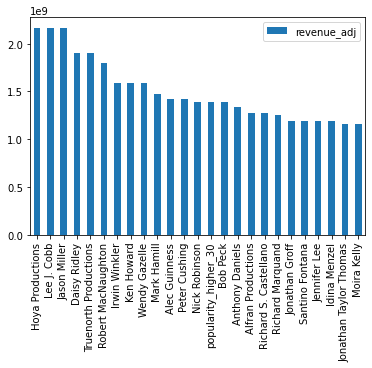

In [1175]:
df_analysis_2.plot.bar();

## Limitation

This study is subject to significant limitations with regards to the applied data analytics process.

The three main points are the following: 

First of all, no true statistical analysis has been performed. In other words, the statistical correlation between variables has not been identified. Similarily, no linear regression models have been conducted. This work has only calculated mean values. Further studies should explore this further.

Secondly, the data analysis is weakened by a lack of data for certain variables, that make conclusive arguments hardly a viable option. For example, Daisy Ridley, an actress and according to the data one of the most conclusive drivers for a high revenue movie, has only been part in one movie. Since that movie has been a success, i.e. it generated high revenues, the analysis suggests so. However, with a sample size of one, the statistical robustness is not given. More data should thus be collected

Thirdly, the data analysis misses a "so what" argument depending on the type of reader. For example, there are  limited implications to be drawn based on the finding, that now defunt production companies have produced movies back in the 1930s that proven to be financially successfull in comparision to current movies, when adjusted for inflation.